In [1]:
'''
필요 라이브러리! 없으면 설치할 것!
설치 방법은 !pip install (라이브러리이름)
'''
import time
import functools
from dataclasses import asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvtrace import *
from pvtrace.geometry.utils import EPS_ZERO

from luminophore import*

# Some packages used by pvtrace are a little noisy
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('numpy').disabled = True
logging.getLogger('matplotlib').disabled = True
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
# ex : pvtrace 없으면 다음 command로 설치하면 됨(주석처리 해제 후)
# !pip install pvtrace

## Experiment design
---

In [19]:
# 재실험시, 다시 이 cell부터 차례대로 실행하면 됨.
###########################################  실험 시 조절하는 변수들 정리 #################################################

air_refractive_index = 1                          # 공기 굴절률
pmma_refractive_index = 1.5                       # Substrate 굴절률(PMMA)
absorption_coeff = 0.1                            # substrate의 흡수 계수(단위 : cm-1)
length, width, depth = 5, 5, 0.25                 # LSC size(단위 : cm, 한 layer 당)



n = 4000                                          # 발사하는 photon 횟수(시뮬레이션에 발사할 숫자. 너무 크면 오래걸려서 적당한 숫자
wavelength_low, wavelength_high = 300, 801        # 실험할 빛의 파장 범위(단위 : nm), 최솟값은 300 이상이 좋아보임(solar spectrum 상에서도 그렇고 luminophore data도 300까지 나와있음.)
x = np.arange(wavelength_low, wavelength_high, dtype=np.float64)

luminophore_file = 'qdot800.csv'
# absorption_spectrum = lumogen_f_red_305.absorption(x)  # units: nm-1
# emission_spectrum = lumogen_f_red_305.emission(x)      # units: nm-1
absorption_spectrum = get_absorption(luminophore_file, wavelength_low, wavelength_high)  # units: nm-1
emission_spectrum = get_emission(luminophore_file, wavelength_low, wavelength_high)      # units: nm-1
luminophore_quantum_yield = 0.95                  # quantum yield 값
###########################################################################################################################

def spherical_to_cart(theta, phi, r=1):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    cart = np.column_stack((x, y, z))
    if cart.size == 3:
        return cart[0, :]
    return cart

def custom_henyey_greenstein(g=0.0):
    """ Henyey-Greenstein phase function.
    """
    # https://www.astro.umd.edu/~jph/HG_note.pdf
    p = np.random.uniform(0, 1)
    s = 2 * p - 1
    mu = 1 / (2 * g) * (1 + g ** 2 - ((1 - g ** 2) / (1 + g * s)) ** 2)
    # Inverse is not defined at g=0 but in the limit
    # tends to the isotropic case.
    phi = 2 * np.pi * np.random.uniform()
    theta = np.arccos(mu)
    coords = spherical_to_cart(theta, phi)
    return coords

#####################################  World(공기층 구현) #################################################################
world = Node(
    name="world (air)",
    geometry=Box(
        (length*100, width*100, depth*100),
        material=Material(refractive_index=air_refractive_index),
    )
)
###########################################################################################################################

##################################### single layer LSC ######################################################################
lsc = Node(
        name="LSC",
        geometry=Box(
            (length, width, depth),
            material=Material(
                refractive_index=pmma_refractive_index,
                components=[
                    Luminophore(
                        coefficient=np.column_stack((x, absorption_spectrum)),
                        emission=np.column_stack((x, emission_spectrum)),
                        quantum_yield=0.95,
                        phase_function=isotropic
                    ),
                    Absorber(coefficient=absorption_coeff)
                    # Scatterer(
                    #     coefficient=1.0, # cm-1
                    #     quantum_yield=1.0,
                    #     phase_function=lambda : custom_henyey_greenstein(g=0.8),
                    # )  
                ]
            ),
        ),
        parent=world,
    )
#############################################################################################################################

##################################### double layer LSC ######################################################################
# lsc = Node(
#     name="lsc",
#     parent=world
# )

# first_layer = Node(
#     name="layer1",
#     geometry=Box(
#         (length, width, depth),
#         material=Material(
#             refractive_index=pmma_refractive_index,
#             components=[
#                 Luminophore(
#                     coefficient=np.column_stack((x, absorption_spectrum)),
#                     emission=np.column_stack((x, emission_spectrum)),
#                     quantum_yield=luminophore_quantum_yield,
#                     phase_function=isotropic
#                 ),
#                 Absorber(coefficient=absorption_coeff)
#             ]
#         ),
#     ),
#     parent=lsc
# )

# second_layer = Node(
#     name="layer2",
#     geometry=Box(
#         (length, width, depth),
#         material=Material(
#             refractive_index=pmma_refractive_index,
#             components=[
#                 Luminophore(
#                     coefficient=np.column_stack((x, absorption_spectrum)),
#                     emission=np.column_stack((x, emission_spectrum)),
#                     quantum_yield=luminophore_quantum_yield,
#                     phase_function=isotropic
#                 ),
#                 Absorber(coefficient=0.1)
#             ]
#         ),
#     ),
#     parent=lsc
# )
# first_layer.location = (0, 0, depth/2)
# second_layer.location = (0, 0, -depth/2)
##########################################################################################################################

##################################### triple layer LSC ######################################################################
# lsc = Node(
#     name="lsc",
#     parent=world
# )

# first_layer = Node(
#     name="layer1",
#     geometry=Box(
#         (length, width, depth),
#         material=Material(
#             refractive_index=pmma_refractive_index,
#             components=[
#                 Luminophore(
#                     coefficient=np.column_stack((x, absorption_spectrum)),
#                     emission=np.column_stack((x, emission_spectrum)),
#                     quantum_yield=luminophore_quantum_yield,
#                     phase_function=isotropic
#                 ),
#                 Absorber(coefficient=absorption_coeff)
#             ]
#         ),
#     ),
#     parent=lsc
# )

# second_layer = Node(
#     name="layer2",
#     geometry=Box(
#         (length, width, depth),
#         material=Material(
#             refractive_index=pmma_refractive_index,
#             components=[
#                 Luminophore(
#                     coefficient=np.column_stack((x, absorption_spectrum)),
#                     emission=np.column_stack((x, emission_spectrum)),
#                     quantum_yield=luminophore_quantum_yield,
#                     phase_function=isotropic
#                 ),
#                 Absorber(coefficient=absorption_coeff)
#             ]
#         ),
#     ),
#     parent=lsc
# )

# third_layer = Node(
#     name="layer3",
#     geometry=Box(
#         (length, width, depth),
#         material=Material(
#             refractive_index=pmma_refractive_index,
#             components=[
#                 Luminophore(
#                     coefficient=np.column_stack((x, absorption_spectrum)),
#                     emission=np.column_stack((x, emission_spectrum)),
#                     quantum_yield=luminophore_quantum_yield,
#                     phase_function=isotropic
#                 ),
#                 Absorber(coefficient=absorption_coeff)
#             ]
#         ),
#     ),
#     parent=lsc
# )
# first_layer.location = (0, 0, depth)
# third_layer.location = (0, 0, -depth)
#############################################################################################################




300 779
600.0 920.0


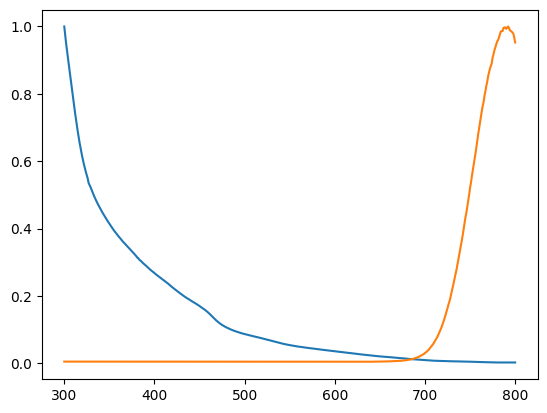

In [20]:
# spectrum 확인용
plt.plot(x, absorption_spectrum)
plt.plot(x, emission_spectrum)

In [21]:
# light 구현
############################# custom function ####################################
# custom mask. 빛이 떨어지는 구역 설정
def custom_mask(X, Y):
    return (np.random.uniform(-X, X), np.random.uniform(-Y, Y), 1.5)

def sampling(low, high, p):
    return np.random.choice(high-low, 1, p=solar)[0] + low

def solar_light(low, high):
    df = pd.read_csv('solar_spectrum.csv')
    spectrum = df[(df['Wavelength']>=low) & (df['Wavelength']<high) & (np.round(df['Wavelength'])==df['Wavelength'])]['Direct+circumsolar']
    return spectrum
##################################################################################
##################  lamp #######################################################
# def lamp_spectrum(x):
#     """ Fit to an experimentally measured lamp spectrum with long wavelength filter.
#     """
#     def g(x, a, p, w):
#         return a * np.exp(-(((p - x) / w)**2 ))
#     a1 = 0.53025700136646192
#     p1 = 512.91400020614333
#     w1 = 93.491838802960473
#     a2 = 0.63578999789955015
#     p2 = 577.63100003089369
#     w2 = 66.031706473985736
#     return g(x, a1, p1, w1) + g(x, a2, p2, w2)

# # Add a custom light
# lamp_dist = Distribution(x, lamp_spectrum(x))
# wavelength_callable = lambda : lamp_dist.sample(np.random.uniform())
#######################################################################

################################ solar (AM1.5G) #####################################
solar = solar_light(wavelength_low, wavelength_high)
solar /= solar.sum()
wavelength_callable = lambda : sampling(wavelength_low, wavelength_high, solar)
##################################################################################

light = Light(
    wavelength=wavelength_callable,
    position=functools.partial(rectangular_mask, length/2, width/2)
)
# light = Light(
#     direction=functools.partial(cone, np.pi/4)
# )
light_node = Node(name='light', light=light, parent=world)
light_node.location = (0.0, 0.0, 1.5)
light_node.rotate(*(np.radians(180), (1, 0, 0)))

scene = Scene(world)

In [22]:
# solar spectrum 확인용
# sample = np.random.choice(wavelength_high-wavelength_low, 10000, p=solar) + wavelength_low
# plt.subplot(211)
# plt.plot(x, solar_light(wavelength_low, wavelength_high))
# plt.subplot(212)
# plt.hist(sample, bins=50)

## Simulation
---

In [23]:
# 렌더링 하는 부분. google colab에선 렌더링 불가하므로 주석처리하기!
renderer = MeshcatRenderer(
    transparency=False,
    wireframe=True,
    opacity = 0.5,
    max_histories=100
)
renderer.render(scene)
renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [18]:
store = {"entrance_rays": [], "exit_rays": []}
history_kwargs = {
    "bauble_radius": None,
    "baubles": True,
    "world_segment": 'short',
    "short_length": None,
}

# 실험 시작!
for ray in scene.emit(n):
    history = photon_tracer.follow(scene, ray, emit_method='kT')
    rays, events = zip(*history)
    store["entrance_rays"].append((rays[1], events[1]))
    if events[-1] in (Event.ABSORB, Event.KILL):
        # final event is a lost store path information at final event
        store["exit_rays"].append((rays[-1], events[-1]))
    elif events[-1] == Event.EXIT:
        # final event hits the world node. Store path information at
        # penultimate location
        store["exit_rays"].append((rays[-2], events[-2]))

    # Update visualiser/google colab이면 이 부분 주석 처리하기.
    if renderer:
        renderer.add_history(history)

KeyboardInterrupt: 

## 실험 결과 정리
---

In [ ]:
# 결과 dataframe에 정리하기
df = pd.DataFrame()

# Rays entering the scene
for ray, event in store["entrance_rays"]:
    rep = asdict(ray)
    rep["kind"] = "entrance"
    rep["event"] = event.name.lower()
    rep = pd.Series(rep).to_frame().T
    df = pd.concat([df, rep])

# Rays exiting the scene
for ray, event in store["exit_rays"]:
    rep = asdict(ray)
    rep["kind"] = "exit"
    rep["event"] = event.name.lower()
    rep = pd.Series(rep).to_frame().T
    df = pd.concat([df, rep])

In [ ]:
# df 정리 확인용
# df

In [ ]:
# direction, position 부분 정리하기
column = 'direction'
coords = np.stack(df[column].values)
df["{}_x".format(column)] = coords[:, 0]
df["{}_y".format(column)] = coords[:, 1]
df["{}_z".format(column)] = coords[:, 2]
df.drop(columns=column, inplace=True)

column = 'position'
coords = np.stack(df[column].values)
df["{}_x".format(column)] = coords[:, 0]
df["{}_y".format(column)] = coords[:, 1]
df["{}_z".format(column)] = coords[:, 2]
df.drop(columns=column, inplace=True)

In [ ]:
# df 정리 확인용
# df

In [ ]:
# photon의 위치 분류하기(어떤 pv에 있는가)
xmin, xmax = -0.5 * length, 0.5 * length
ymin, ymax = -0.5 * width, 0.5 * width
zmin, zmax = -0.5 * depth, 0.5 * depth    # single layer 용 z
# zmin, zmax = -depth, depth    # double layer 용 z
# zmin, zmax = - 1.5*depth, 1.5*depth    # triple layer 용 z

df.loc[(np.isclose(df["position_x"], xmin, atol=EPS_ZERO)), "facet"] = "left"
df.loc[(np.isclose(df["position_x"], xmax, atol=EPS_ZERO)), "facet"] = "right"
df.loc[(np.isclose(df["position_y"], ymin, atol=EPS_ZERO)), "facet"] = "far"
df.loc[(np.isclose(df["position_y"], ymax, atol=EPS_ZERO)), "facet"] = "near"
df.loc[(np.isclose(df["position_z"], zmin, atol=EPS_ZERO)), "facet"] = "bottom"
df.loc[(np.isclose(df["position_z"], zmax, atol=EPS_ZERO)), "facet"] = "top"

In [ ]:
# 잘 분류 됐는지 확인용
# df
df[df['facet']=='right']['source'].unique()

In [89]:
# photon count하여 정리
all_components = {Luminophore}
all_lights = {Light}

# Count solar photons exiting
solar_out = dict()
for facet in {"left", "right", "near", "far", "top", "bottom"}:
    solar_out[facet] = df[(df['facet']==facet) & (df['source']=='Light') & (df['kind']=='exit')].shape[0]

# # Count solar photons entering
solar_in = dict()
for facet in {"left", "right", "near", "far", "top", "bottom"}:
    solar_in[facet] = df[(df['facet']==facet) & (df['source']=='Light') & (df['kind']=='entrance')].shape[0]

# # Count luminescent photons exiting
lum_out = dict()
for facet in {"left", "right", "near", "far", "top", "bottom"}:
    lum_out[facet] = df[(df['facet']==facet) & (df['source']=='Luminophore') & (df['kind']=='exit')].shape[0]

# # Count luminescent photons entering
lum_in = dict()
for facet in {"left", "right", "near", "far", "top", "bottom"}:
    lum_in[facet] = df[(df['facet']==facet) & (df['source']=='Luminophore') & (df['kind']=='entrance')].shape[0]
    
counts = pd.DataFrame(
    {
        "Solar In": pd.Series(solar_in),
        "Solar Out": pd.Series(solar_out),
        "Luminescent Out": pd.Series(lum_out),
        "Luminescent In": pd.Series(lum_in),
    },
    index=["left", "right", "near", "far", "top", "bottom"],
)

In [90]:
# count 정보 바탕으로 효율 계산
all_facets = {"left", "right", "near", "far", "top", "bottom"}

lum_collected = 0
for facet in {'left', 'right', 'near', 'far'}:
    lum_collected += counts["Luminescent Out"][facet]

lum_escaped = 0
for facet in all_facets -  {'left', 'right', 'near', 'far'}:
    lum_escaped += counts["Luminescent Out"][facet]

incident = 0
for facet in all_facets:
    incident += counts["Solar In"][facet]

# lost = self.spectrum(source="all", events={"absorb"}, kind="last").shape[0]
lost = df[(df['event']=='absorb') & (df['kind']=='exit')].shape[0]

optical_efficiency = lum_collected / incident
waveguide_efficiency = lum_collected / (lum_collected + lum_escaped)

l, w, d = length, width, depth
a1 = w * l
a2 = 2 * l * d + 2 * w * d
Cg = a1 / a2
n = pmma_refractive_index
s = pd.Series(
    {
        "Optical Efficiency": optical_efficiency,
        "Waveguide Efficiency": waveguide_efficiency,
        "Waveguide Efficiency (Thermodynamic Prediction)": (
            n ** 2 / (Cg + n ** 2)
        ),
        "Non-radiative Loss (fraction):": lost / incident,
        "Incident": incident,
        "Geometric Concentration": Cg,
        "Refractive Index": n,
        "Cell Surfaces": {'left', 'right', 'near', 'far'},
    }
)
counts

,Solar In,Solar Out,Luminescent Out,Luminescent In
left,0,0,6,0
right,0,0,1,0
near,0,0,9,0
far,0,0,10,0
top,4000,290,11,0
bottom,0,3516,8,0


In [91]:
# 결과 출력
print(counts)
print('---------------------------------------------------------------')
print(s)

        Solar In  Solar Out  Luminescent Out  Luminescent In
left           0          0                6               0
right          0          0                1               0
near           0          0                9               0
far            0          0               10               0
top         4000        290               11               0
bottom         0       3516                8               0
---------------------------------------------------------------
Optical Efficiency                                                   0.0065
Waveguide Efficiency                                               0.577778
Waveguide Efficiency (Thermodynamic Prediction)                    0.310345
Non-radiative Loss (fraction):                                      0.03725
Incident                                                               4000
Geometric Concentration                                                 5.0
Refractive Index                                     

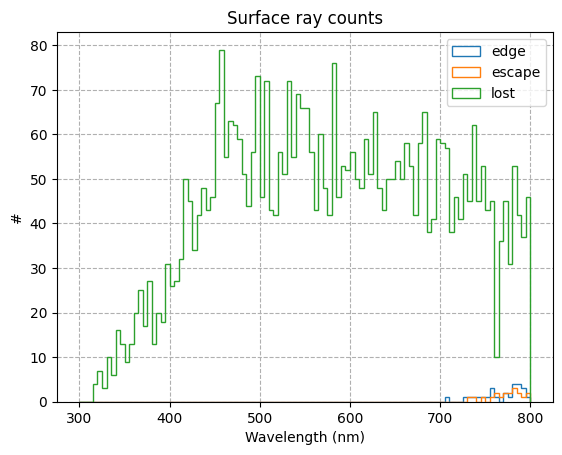

In [92]:
# 파장에 따른 photon의 상태 그래프화 하기
# Get luminescent wavelengths from edge
# edge = lsc.spectrum(facets={'left', 'right', 'near', 'far'}, source={'Fluro Red'})
edge = df[(df['facet']=='left')|(df['facet']=='right')|(df['facet']=='near')|(df['facet']=='far')]['wavelength']

# Get luminescent wavelengths from top and bottom
# escape = lsc.spectrum(facets={'top', 'bottom'}, source={'Fluro Red'})
escape = df[((df['facet']=='top')|(df['facet']=='bottom'))&(df['source']=='Luminophore')]['wavelength']

# Get incident wavelengths into top surface
# lost = lsc.spectrum(facets={'top'}, source="Oriel Lamp + Filter", kind='first')
lost = df[(df['facet']=='top')&(df['source']=='Light')]['wavelength']

plt.hist(edge, bins=np.arange(wavelength_low, wavelength_high, 5), label="edge", histtype='step')
plt.hist(escape, bins=np.arange(wavelength_low, wavelength_high, 5), label="escape",  histtype='step')
plt.hist(lost, bins=np.arange(wavelength_low, wavelength_high, 5), label="lost",  histtype='step')
plt.xlabel('Wavelength (nm)')
plt.ylabel('#')
plt.title("Surface ray counts")
plt.grid(linestyle="dashed")
plt.legend()